In [1]:
import sys
import os 
import kagglehub
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")
sys.path.append(path)


dir = os.path.join(path,"raw-img")
data = []

class_to_id = {
    "cane": 0,
    "cavallo": 1,
    "elefante": 2,
    "farfalla": 3,
    "gallina": 4,
    "gatto": 5,
    "mucca": 6,
    "pecora": 7,
    "ragno": 8,
    "scoiattolo": 9
}

id_to_name = {
    0: "dog",
    1: "horse",
    2: "elephant",
    3: "butterfly",
    4: "chicken",
    5: "cat",
    6: "cow",
    7: "sheep",
    8: "spider",
    9: "squirrel"
}

for key,label in class_to_id.items():
    file_path = os.path.join(dir,key)
    for img_name in os.listdir(file_path):
        img_path = os.path.join(file_path,img_name)
        data.append({"image": img_path,"label":label})

x = [item["image"] for item in data]
y = [item["label"] for item in data]

# stratify ensures class distribution is preserved in each split
x_trainval,x_test,y_trainval,y_test = train_test_split(
    x,y,test_size=0.2,random_state=42,stratify=y
)

x_train,x_val,y_train,y_val = train_test_split(
    x_trainval,y_trainval,test_size=0.1,random_state=42,stratify=y_trainval
)

df_train = pd.DataFrame({
    "filename": x_train, 
    "class": [id_to_name[label] for label in y_train]
})

df_val = pd.DataFrame({
    "filename": x_val,
    "class": [id_to_name[label] for label in y_val]
})

df_test = pd.DataFrame({
    "filename": x_test,
    "class": [id_to_name[label] for label in y_test]
})

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,x_col="filename",y_col="class",target_size=(224,224),batch_size=32,shuffle=True,class_mode="categorical")
val_generator = val_datagen.flow_from_dataframe(df_val,x_col="filename",y_col="class",target_size=(224,224),batch_size=32,shuffle=True,class_mode="categorical")
test_generator = test_datagen.flow_from_dataframe(df_test,x_col="filename",y_col="class",target_size=(224,224),batch_size=32    ,shuffle=True,class_mode="categorical")

Found 18848 validated image filenames belonging to 10 classes.
Found 2095 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [4]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# add custom classifier on top
x = base_model.output
x = Flatten()(x)
x = Dense(256,activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
es = EarlyStopping(monitor="val_accuracy",restore_best_weights=True, patience=10)
optimizer = SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
mc = ModelCheckpoint("best_vgg16_animals10.h5",monitor="val_accuracy",mode="max",save_best_only=True)
history = model.fit(train_generator,validation_data=val_generator,epochs=30,callbacks=[mc,es])

Epoch 1/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2673 - loss: 2.0830

589/589 ━━━━━━━━━━━━━━━━━━━━ 1087s 2s/step - accuracy: 0.3400 - loss: 1.8797 - val_accuracy: 0.5079 - val_loss: 1.4391
Epoch 2/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4150 - loss: 1.6262

589/589 ━━━━━━━━━━━━━━━━━━━━ 994s 2s/step - accuracy: 0.4236 - loss: 1.5882 - val_accuracy: 0.5790 - val_loss: 1.2246
Epoch 3/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 1969s 3s/step - accuracy: 0.4431 - loss: 1.4996 - val_accuracy: 0.5723 - val_loss: 1.1406
Epoch 4/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4459 - loss: 1.5080

589/589 ━━━━━━━━━━━━━━━━━━━━ 1743s 3s/step - accuracy: 0.4507 - loss: 1.4910 - val_accuracy: 0.6000 - val_loss: 1.1299
Epoch 5/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4768 - loss: 1.4059

589/589 ━━━━━━━━━━━━━━━━━━━━ 1302s 2s/step - accuracy: 0.4815 - loss: 1.3967 - val_accuracy: 0.6191 - val_loss: 1.0353
Epoch 6/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4898 - loss: 1.3590

589/589 ━━━━━━━━━━━━━━━━━━━━ 1868s 3s/step - accuracy: 0.4941 - loss: 1.3594 - val_accuracy: 0.6301 - val_loss: 1.0078
Epoch 7/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5034 - loss: 1.3377

589/589 ━━━━━━━━━━━━━━━━━━━━ 1210s 2s/step - accuracy: 0.4986 - loss: 1.3368 - val_accuracy: 0.6520 - val_loss: 0.9859
Epoch 8/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5182 - loss: 1.2913

589/589 ━━━━━━━━━━━━━━━━━━━━ 1129s 2s/step - accuracy: 0.5178 - loss: 1.2970 - val_accuracy: 0.6692 - val_loss: 0.9794
Epoch 9/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 1162s 2s/step - accuracy: 0.5172 - loss: 1.2919 - val_accuracy: 0.6172 - val_loss: 0.9768
Epoch 10/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 2405s 4s/step - accuracy: 0.5283 - loss: 1.2626 - val_accuracy: 0.6601 - val_loss: 0.9616
Epoch 11/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5380 - loss: 1.2371

589/589 ━━━━━━━━━━━━━━━━━━━━ 2067s 4s/step - accuracy: 0.5323 - loss: 1.2554 - val_accuracy: 0.6754 - val_loss: 0.9613
Epoch 12/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.5396 - loss: 1.2351 - val_accuracy: 0.6396 - val_loss: 1.0212
Epoch 13/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5448 - loss: 1.2281

589/589 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.5482 - loss: 1.2179 - val_accuracy: 0.6907 - val_loss: 0.9030
Epoch 14/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 967s 2s/step - accuracy: 0.5553 - loss: 1.2020 - val_accuracy: 0.6792 - val_loss: 0.9126
Epoch 15/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5662 - loss: 1.1830

589/589 ━━━━━━━━━━━━━━━━━━━━ 966s 2s/step - accuracy: 0.5669 - loss: 1.1968 - val_accuracy: 0.7017 - val_loss: 0.9314
Epoch 16/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.5775 - loss: 1.1718 - val_accuracy: 0.6783 - val_loss: 0.9740
Epoch 17/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5630 - loss: 1.1894

589/589 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.5592 - loss: 1.1937 - val_accuracy: 0.7193 - val_loss: 0.8965
Epoch 18/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5628 - loss: 1.1741

589/589 ━━━━━━━━━━━━━━━━━━━━ 973s 2s/step - accuracy: 0.5587 - loss: 1.1832 - val_accuracy: 0.7365 - val_loss: 0.8492
Epoch 19/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.5651 - loss: 1.1723 - val_accuracy: 0.6821 - val_loss: 0.9990
Epoch 20/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 963s 2s/step - accuracy: 0.5636 - loss: 1.1800 - val_accuracy: 0.7212 - val_loss: 0.8960
Epoch 21/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.5858 - loss: 1.1360 - val_accuracy: 0.6907 - val_loss: 0.9266
Epoch 22/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5933 - loss: 1.1311

589/589 ━━━━━━━━━━━━━━━━━━━━ 964s 2s/step - accuracy: 0.5955 - loss: 1.1225 - val_accuracy: 0.7475 - val_loss: 0.8521
Epoch 23/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.5953 - loss: 1.1201 - val_accuracy: 0.7403 - val_loss: 0.8437
Epoch 24/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5881 - loss: 1.1278

589/589 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.5901 - loss: 1.1228 - val_accuracy: 0.7556 - val_loss: 0.8381
Epoch 25/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.5999 - loss: 1.1164 - val_accuracy: 0.6916 - val_loss: 0.9215
Epoch 26/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 967s 2s/step - accuracy: 0.6023 - loss: 1.0979 - val_accuracy: 0.6993 - val_loss: 0.8772
Epoch 27/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.6052 - loss: 1.0949 - val_accuracy: 0.7155 - val_loss: 0.8550
Epoch 28/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.5963 - loss: 1.0983 - val_accuracy: 0.7418 - val_loss: 0.8077
Epoch 29/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 966s 2s/step - accuracy: 0.6026 - loss: 1.0850 - val_accuracy: 0.7461 - val_loss: 0.7968
Epoch 30/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.6077 - loss: 1.0777 - val_accuracy: 0.7341 - val_loss: 0.8308


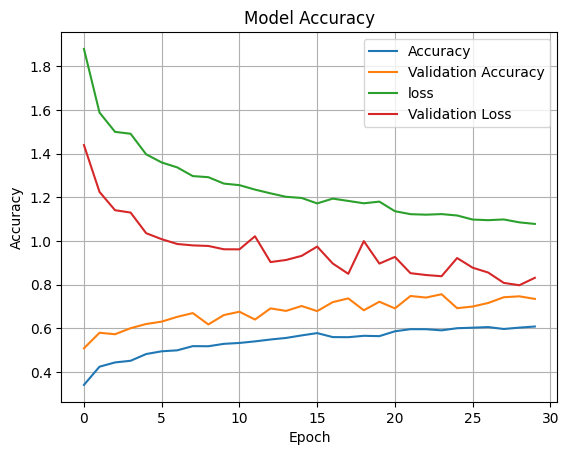

In [7]:
plt.plot(history.history["accuracy"]) # train
plt.plot(history.history["val_accuracy"]) # validation
plt.plot(history.history["loss"]) # train
plt.plot(history.history["val_loss"]) # validation
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [8]:
test_loss,test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7752 - loss: 0.8180
Test Accuracy: 0.7752
